In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Завантаження необхідних ресурсів NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annbu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annbu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\annbu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('order_reviews.csv')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Перевірка на пропущені значення
print(df['review_comment_title'].isna().sum())
print(df['review_comment_message'].isna().sum())


# Заповнення пропущених значень порожніми рядками
df['review_comment_title'] = df['review_comment_title'].fillna('')
df['review_comment_message'] = df['review_comment_message'].fillna('')

88285
58247


In [5]:
# обробка тексту
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['processed_text'] = (df['review_comment_title'].fillna('') + ' ' + df['review_comment_message'].fillna(''))
df['processed_text'] = df['processed_text'].apply(preprocess_text)

In [6]:
# створення міток
def create_sentiment_label(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['review_score'].apply(create_sentiment_label)

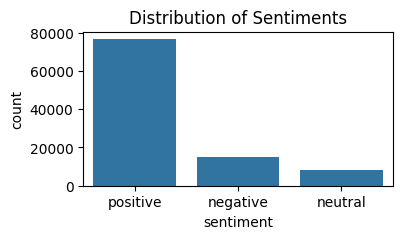

In [7]:
# візуалізація розподілу сентиментів
plt.figure(figsize=(4, 2))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

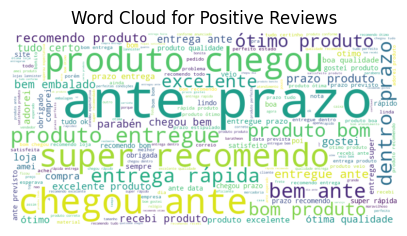

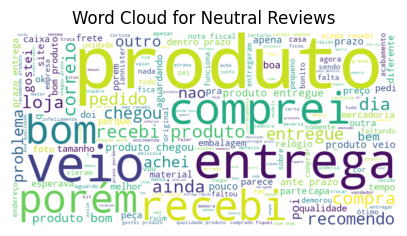

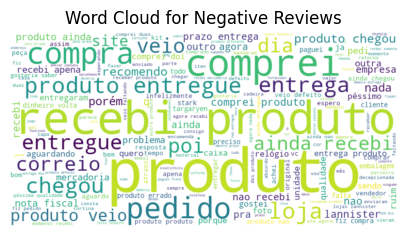

In [8]:
# створення word cloud для кожного сентименту
for sentiment in ['positive', 'neutral', 'negative']:
    text = ' '.join(df[df['sentiment'] == sentiment]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Reviews')
    plt.show()

In [9]:
X = df['processed_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# випробування різних моделей
pipelines = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]),
    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', SVC())
    ])
}

In [21]:
# параметри для оптимізації
parameters = {
    'Naive Bayes': {
        'tfidf__max_features': [3000, 5000],
        'clf__alpha': [0.1, 1.0]
    },
    'Logistic Regression': {
        'tfidf__max_features': [3000, 5000],
        'clf__C': [0.1, 1.0],
        'clf__max_iter': [1000]
    },
    'SVM': {
        'tfidf__max_features': [3000, 5000],
        'clf__C': [0.1, 1.0],
        'clf__kernel': ['linear', 'rbf']
    }
}

In [22]:
# оптимізація гіперпараметрів та навчання моделей
best_models = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, parameters[name], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for Naive Bayes:
{'clf__alpha': 0.1, 'tfidf__max_features': 3000}
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters for Logistic Regression:
{'clf__C': 1.0, 'clf__max_iter': 1000, 'tfidf__max_features': 3000}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

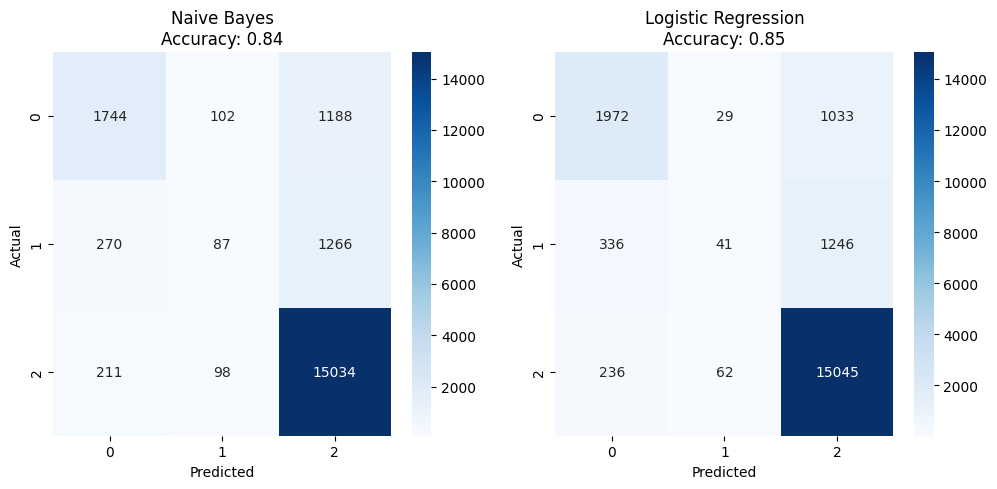


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    negative       0.78      0.57      0.66      3034
     neutral       0.30      0.05      0.09      1623
    positive       0.86      0.98      0.92     15343

    accuracy                           0.84     20000
   macro avg       0.65      0.54      0.56     20000
weighted avg       0.80      0.84      0.81     20000


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    negative       0.78      0.65      0.71      3034
     neutral       0.31      0.03      0.05      1623
    positive       0.87      0.98      0.92     15343

    accuracy                           0.85     20000
   macro avg       0.65      0.55      0.56     20000
weighted avg       0.81      0.85      0.82     20000



In [23]:
# оцінка моделей та візуалізація результатів
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(best_models.items(), 1):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name}\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

In [24]:
# вибір найкращої моделі (за accuracy)
best_model_name = max(best_models, key=lambda x: accuracy_score(y_test, best_models[x].predict(X_test)))
best_model = best_models[best_model_name]
print(f"\nBest model: {best_model_name}")


Best model: Logistic Regression


In [25]:
# функція для класифікації нових коментарів
def classify_comment(comment):
    return best_model.predict([comment])[0]

# 12. Приклади використання моделі
example_comments = [
    "O produto é excelente, superou minhas expectativas!",
    "A entrega foi rápida, mas o produto não é tão bom quanto eu esperava.",
    "Produto ok, nada demais.",
    "Péssimo atendimento, nunca mais compro nesta loja!",
    "Adorei o produto, recomendo a todos!"
]

print("\nПриклади класифікації коментарів:")
for comment in example_comments:
    sentiment = classify_comment(comment)
    print(f"Коментар: {comment}")
    print(f"Сентимент: {sentiment}\n")




Приклади класифікації коментарів:
Коментар: O produto é excelente, superou minhas expectativas!
Сентимент: positive

Коментар: A entrega foi rápida, mas o produto não é tão bom quanto eu esperava.
Сентимент: positive

Коментар: Produto ok, nada demais.
Сентимент: positive

Коментар: Péssimo atendimento, nunca mais compro nesta loja!
Сентимент: negative

Коментар: Adorei o produto, recomendo a todos!
Сентимент: positive



In [ ]:
# інтерактивне введення користувача
while True:
    user_comment = input("Введіть коментар для класифікації (або 'quit' для виходу): ")
    if user_comment.lower() == 'quit':
        break
    sentiment = classify_comment(user_comment)
    print(f"Сентимент: {sentiment}\n")

In [23]:
import re
from termcolor import colored

def extract_price(comment):
    # шаблон для пошуку цін у різних форматах
    price_pattern = r'\$?\s?(\d+(?:[.,]\d{1,2})?)\s?(?:USD|R\$|\$)?'
    
    # знаходимо всі збіги в коментарі
    matches = re.findall(price_pattern, comment, re.IGNORECASE)
    
    # обробляємо знайдені збіги
    prices = []
    for match in matches:
        # заміняємо кому на крапку для правильного перетворення у float
        price = float(match.replace(',', '.'))
        prices.append(price)
    
    return prices, matches

In [24]:
def highlight_prices(comment, matches):
    highlighted_comment = comment
    for match in matches:
        highlighted_comment = re.sub(re.escape(match), colored(match, 'red'), highlighted_comment, flags=re.IGNORECASE)
    return highlighted_comment

In [25]:
def analyze_price_comment(comment):
    prices, matches = extract_price(comment)
    
    if not prices:
        return "У коментарі не знайдено згадок про ціну."
    
    highlighted_comment = highlight_prices(comment, matches)
    result = f"Коментар: {highlighted_comment}\nЗнайдено {len(prices)} згадок про ціну:\n"
    for i, price in enumerate(prices, 1):
        result += f"{i}. {price}\n"
    
    return result.strip()

In [26]:
# приклади використання
example_comments = [
    "O produto custa 50,00 e vale cada centavo!",
    "I bought it for $29.99 and it's amazing.",
    "Paguei 100 reais e achei caro.",
    "The price increased from $20 to $25 last month.",
    "É um bom negócio por R$75,50.",
    "Não menciona preço neste comentário.",
    "It costs twenty dollars.",  
    "The prices range from R$ 30 to R$ 50.",
]

for comment in example_comments:
    print(analyze_price_comment(comment))
    print()

Коментар: O produto custa 50,00 e vale cada centavo!
Знайдено 1 згадок про ціну:
1. 50.0

Коментар: I bought it for $29.99 and it's amazing.
Знайдено 1 згадок про ціну:
1. 29.99

Коментар: Paguei 100 reais e achei caro.
Знайдено 1 згадок про ціну:
1. 100.0

Коментар: The price increased from $20 to $25 last month.
Знайдено 2 згадок про ціну:
1. 20.0
2. 25.0

Коментар: É um bom negócio por R$75,50.
Знайдено 1 згадок про ціну:
1. 75.5

У коментарі не знайдено згадок про ціну.

У коментарі не знайдено згадок про ціну.

Коментар: The prices range from R$ 30 to R$ 50.
Знайдено 2 згадок про ціну:
1. 30.0
2. 50.0



In [ ]:
# інтерактивне введення користувача
while True:
    user_comment = input("Введіть коментар для аналізу ціни (або 'quit' для виходу): ")
    if user_comment.lower() == 'quit':
        break
    print(analyze_price_comment(user_comment))
    print()